In [7]:
# Importar librerías
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

In [8]:
# Cargar datos, modelo y métricas anteriores
processed_data_path = '../../data/processed/final_processed_data.parquet'
features_path = '../../data/processed/final_features.json'
model_path = '../../models/xgboost_tuned_pipeline.joblib'
previous_metrics_path = '../../models/xgboost_tuned_metrics.json'

df = pd.read_parquet(processed_data_path)
with open(features_path, 'r') as f:
    final_features = json.load(f)

best_model = joblib.load(model_path)
with open(previous_metrics_path, 'r') as f:
    previous_metrics = json.load(f)

print("Datos, modelo y métricas anteriores cargados.")

Datos, modelo y métricas anteriores cargados.


In [9]:
# Preparar datos
target_column = 'precio_mxn'
X = df[final_features]
y = df[target_column]

# Asegurarse de que no hay NaNs
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]

print(f"Datos listos para validación cruzada. Número de muestras: {len(X)}")

Datos listos para validación cruzada. Número de muestras: 8893


In [10]:
# Realizar Validación Cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error',
    'neg_rmse': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))),
    'neg_mae': 'neg_mean_absolute_error'
}

print("Iniciando validación cruzada con 10 pliegues...")
cv_results = cross_validate(best_model, X, y, cv=kf, scoring=scoring, n_jobs=-1)
print("Validación cruzada completada.")

# Convertir scores negativos a positivos
cv_r2 = cv_results['test_r2']
cv_mse = -cv_results['test_neg_mse']
cv_rmse = -cv_results['test_neg_rmse']
cv_mae = -cv_results['test_neg_mae']

print("\n--- Resultados de la Validación Cruzada ---")
print(f"R² (promedio): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"MSE (promedio): {cv_mse.mean():.4f} ± {cv_mse.std():.4f}")
print(f"RMSE (promedio): {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
print(f"MAE (promedio): {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")

Iniciando validación cruzada con 10 pliegues...
Validación cruzada completada.

--- Resultados de la Validación Cruzada ---
R² (promedio): 0.8055 ± 0.0065
MSE (promedio): 183123259.6842 ± 33874277.0732
RMSE (promedio): 13479.0339 ± 1199.5431
MAE (promedio): 7734.7373 ± 341.7482


In [11]:
# Comparación con la evaluación de prueba única
single_test_metrics = previous_metrics['test_metrics']

comparison_data = {
    'Métrica': ['R²', 'MSE', 'RMSE', 'MAE'],
    'Prueba Única (single split)': [
        single_test_metrics['r2'],
        single_test_metrics['mse'],
        single_test_metrics['rmse'],
        single_test_metrics['mae']
    ],
    'Validación Cruzada (promedio)': [
        cv_r2.mean(),
        cv_mse.mean(),
        cv_rmse.mean(),
        cv_mae.mean()
    ]
}
comparison_df = pd.DataFrame(comparison_data)

print("--- Comparación de Métricas ---")
print(comparison_df.to_string(index=False))

--- Comparación de Métricas ---
Métrica  Prueba Única (single split)  Validación Cruzada (promedio)
     R²                 8.044335e-01                   8.054869e-01
    MSE                 1.644964e+08                   1.831233e+08
   RMSE                 1.282561e+04                   1.347903e+04
    MAE                 7.571264e+03                   7.734737e+03


/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_46454/2051167483.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cv_r2, ax=axes[0], palette='viridis')
/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_46454/2051167483.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), ax=axes[1], palette='cividis')


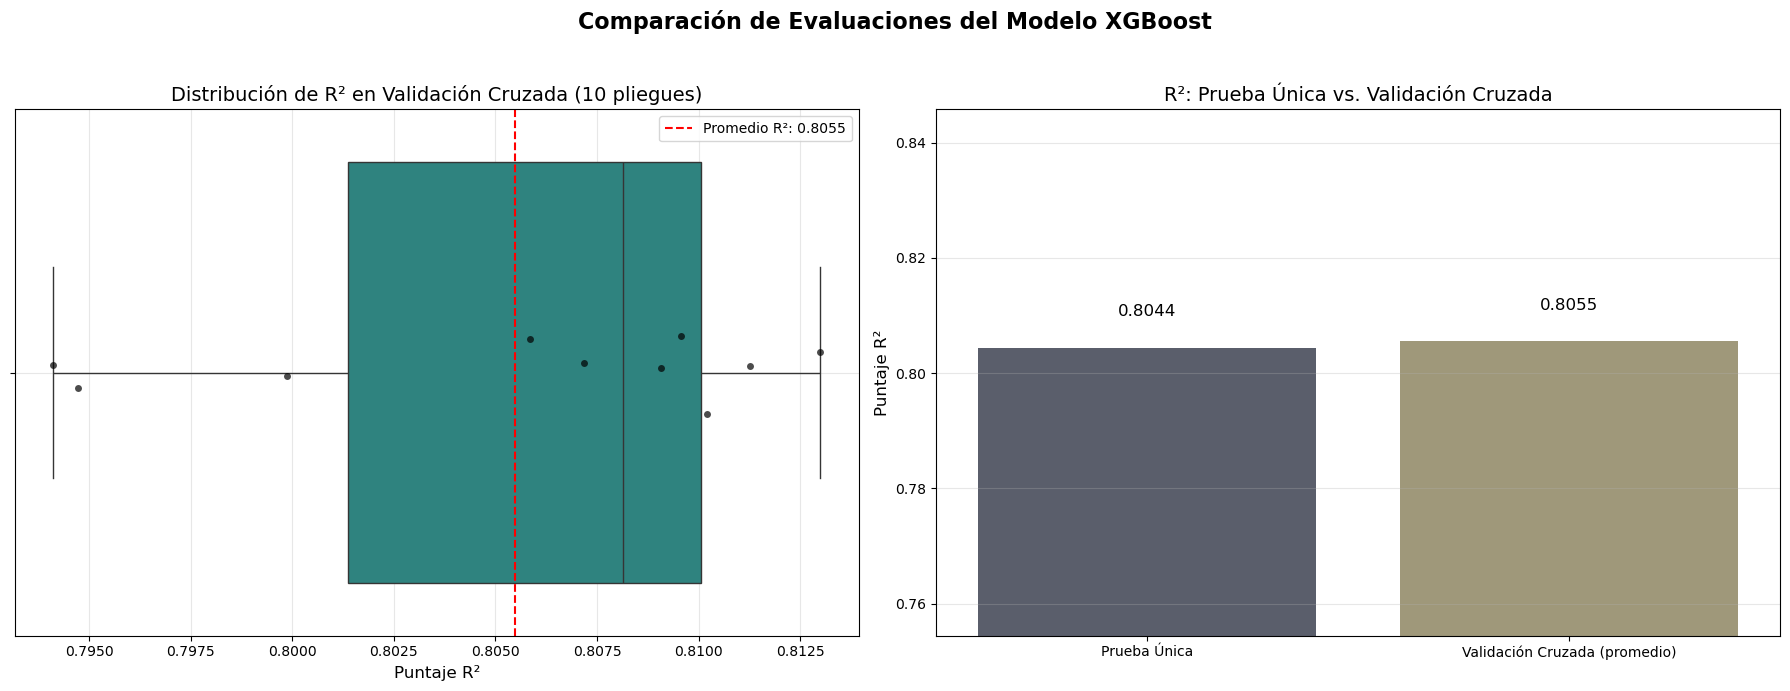

In [12]:
# Visualización de Resultados
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Comparación de Evaluaciones del Modelo XGBoost', fontsize=16, weight='bold')

# 1. Distribución de R² en Validación Cruzada
sns.boxplot(x=cv_r2, ax=axes[0], palette='viridis')
sns.stripplot(x=cv_r2, ax=axes[0], color='black', alpha=0.7, jitter=0.1)
axes[0].set_title('Distribución de R² en Validación Cruzada (10 pliegues)', fontsize=14)
axes[0].set_xlabel('Puntaje R²', fontsize=12)
axes[0].axvline(cv_r2.mean(), color='red', linestyle='--', label=f'Promedio R²: {cv_r2.mean():.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Comparación de R²: Prueba Única vs. Validación Cruzada
r2_scores = {
    'Prueba Única': single_test_metrics['r2'],
    'Validación Cruzada (promedio)': cv_r2.mean()
}
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()), ax=axes[1], palette='cividis')
axes[1].set_title('R²: Prueba Única vs. Validación Cruzada', fontsize=14)
axes[1].set_ylabel('Puntaje R²', fontsize=12)
axes[1].set_ylim(bottom=max(0, min(list(r2_scores.values())) - 0.05))
for i, score in enumerate(r2_scores.values()):
    axes[1].text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontsize=12)
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()